<a href="https://colab.research.google.com/github/Ahmed-Wassel-Angar/Car-Insurance-Binary-Classification-In-Progress/blob/main/Project_2_Car_Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CONTEXT:**

- **Stakeholders:** An insurance car company.
- **Context:** The company shared its annual car insurance data and intend comprehend customer behaviors.
- **Dataset:**
  - The dataset has 19 features from there 18 of them are corresponding logs which were taken by the company.
  - The outcome column indicates whether a customer has claimed(1) his loan else (0).
- **Data Dictionary:** ID/ AGE/ GENDER/ RACE/ DRIVING EXPERIENCE/ EDUCATION/ INCOME/ CREDIT SCORE/ VEHICULE OWNERSHIP/ VEHICULE YEAR/ MARRIED/ CHILDREN/ POSTAL CODE/ ANNUAL MILEAGE/ VEHICULE TYPE/ SPEEDING VIOLATIONS/ DUIS/ PAST ACCIDENTS/ OUTCOME.
- **Data Souce:** Public dataset from Kaggle with real observations.


  

# **INSTANTIATING CUSTOMIZED FUNCTIONS**

In [26]:
#@title **Overview Data**

def overview(dataset):
  from google.colab import data_table
  data_table.enable_dataframe_formatter()

  df=dataset.copy()
  header="-"*25

  print(2*header,"START - OVERVIEW DATA",2*header)
  display(df.head(10))

  print(4*header, f"Dataset Statistics:", 4*header, sep='\n')

  num_cols = df.select_dtypes('number').columns
  cat_cols = df.select_dtypes('object').columns
  nbr_num_cols = len(num_cols)
  nbr_cat_cols = len(cat_cols)
  nbr_duplicated = df.duplicated().sum()
  nbr_missing = df.isna().sum().sum()
  nbr_obsol_rows = df.shape[0]-len(df.dropna(how='all'))
  nbr_obsol_columns = df.shape[1]-len(df.dropna(how='all',axis=1).columns)

  overview=pd.Series(index=["Number of variables:","Number of observations:","Duplicated rows:","Obsolete rows(empty rows):","Obsolete variables(empty columns):","Total Missing Values:"],
                     data=[f"{df.shape[1]} ({nbr_num_cols} numeric and {nbr_cat_cols} categorical)",
                           f"{df.shape[0]}",
                           f"{nbr_duplicated} ({nbr_duplicated/df.shape[0] *100:,.2f}%)",
                           f"{nbr_obsol_rows} ({nbr_obsol_rows/df.shape[0] *100:,.2f}%)",
                           f"{nbr_obsol_columns} ({nbr_obsol_columns/df.shape[1] *100:,.2f}%)",
                           f"{nbr_missing} ({nbr_missing/(df.shape[0]*df.shape[1]) *100:,.2f}%)"])
  print(overview.to_string())

  print(4*header, f"Numeric features: {nbr_num_cols} columns", sep='\n')
  print(num_cols.values)

  print(4*header, f"Categorical features: {nbr_cat_cols} columns", sep='\n')
  print(cat_cols.values)

  print(4*header, f"Missing Values per feature:", sep='\n')
  df_miss=df.loc[:,df.isna().any(axis=0)]
  truncate = df_miss.isna().mean() > 0
  missing_values_counts=pd.DataFrame({'Missing values': df_miss.loc[:, truncate].isna().sum(), 'Percentage': df_miss.loc[:, truncate].isna().mean().map('{:,.3f}'.format)}).sort_values(by = 'Missing values', ascending = False)
  #frame={'Counts':len(df),
  #       'Missing values':df.isna().sum(),
  #       'Percentage':df.isna().sum()/df.shape[0] *100}
  #missing_values_counts = pd.DataFrame(frame)
  #missing_values_counts.loc[:,"Percentage"]=missing_values_counts["Percentage"].map('{:,.2f} %'.format)
  #missing_values_counts=missing_values_counts.sort_values(by='Missing values',ascending=False)
  #display(missing_values_counts.style)
  print(missing_values_counts)
  fig = plt.figure(figsize=(20,15))
  axes1 = fig.add_subplot(2,2,1)
  msno.bar(df_miss,ax=axes1,color='blue',fontsize=12)
  axes1.tick_params(axis='x',rotation=90)
  axes2 = fig.add_subplot(2,2,2)
  msno.matrix(df_miss,ax=axes2,sort='descending',fontsize=12)
  axes2.tick_params(axis='x',rotation=90)
  axes3 = fig.add_subplot(2,2,3)
  msno.heatmap(df_miss,ax=axes3,fontsize=12)
  axes3.tick_params(axis='x',rotation=90)
  axes4= fig.add_subplot(2,2,4)
  msno.dendrogram(df_miss,ax=axes4,fontsize=12,orientation='top')
  axes4.tick_params(axis='x',rotation=90)
  plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
  plt.show()

  data_table.disable_dataframe_formatter()

  print(2*header,"END - OVERVIEW DATA",2*header)


In [27]:
#@title **Explore Numerical Univariations**
def numerical_univariations(df,columns=None,iqr_coef=1.5,imb_threshold=0.1,out_threshold=0.05):
  """Explores numeric columns within a dataset.

  Parameters
  ----------
  df : Dataframe
      The dataset to be explored.
  columns : iterable, optional
      The array of the numeric columns' names(str) to include. if None, all numeric columns will be included.
  target : str, optional
      The target column's name. if None, dependency exploration vs the numeric columns won't be included.
  iqr_coef : float, defaul = 1.5
      The interquantile coefficient included in the detection of outliers. 'Q1'(or'Q3') - (or '+')iqr_coef*IQR
  imb_threshold : float, default = 0.1
      Threshold past it a category is imbalanced. exples: a column with 3 distinct values and an imb_threshold=0.2 is imbalanced when any of its values's imb_threshold>0.4((1+0.2)*1/3))
  out_threshold : float, default = 0.05
      the percentage(out_threshold*100) of the number of outliers (outside the IQR range) above which a warning is displayed.
  corr_threshold : float, default = 0.3
      The level of abs(correlation) above which two columns will be considered correlated. When correlated, a warning and the corressponding regplot will be displayed.

  Returns
  -------
  - Numeric columns considered in the exploration.
  - Nulls for each columns.
  - Total number of distinct values for each column, and top ten values.
  - Descriptive statistics for each column.
  - Quantile statistics for each coulmn.
  - Value counts for each column.
  - The distribution and the boxplot for each colum.
  - Alerts detected for each column (including symetry, skewness, outliers, cardinality, imbalance and constancy)
"""
  from sklearn.feature_selection import VarianceThreshold
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns
  import math

  if columns is None:
    num_cols = df.select_dtypes('number').columns
  else:
    num_cols = df[columns].select_dtypes('number').columns

  sns.set_style("whitegrid")
  sns.set(font_scale=0.8)
  header="-"*25


  vr = VarianceThreshold(threshold = 0.01)
  num_cols = df.select_dtypes('number').columns
  x=df[num_cols].dropna(how='any',axis=0)
  vr = VarianceThreshold(threshold = 0.02) # only columns with more than 2% variance are retained
  vr.fit(x)
  vr_filter = x.columns[~vr.get_support()] # List of columns with less than 2% variance
  print(2*header,"START - EXPLORE NUMERIC",2*header)
  print(" "*80,sep="\n")
  print(f"Numeric features: {len(num_cols)} columns",sep="\n")
  print(f"- List of columns: {num_cols.values}  ",sep="\n")
  print(f"- Columns with less than 2% variance: {vr_filter.values if len(vr_filter)!=0 else 'None'}  ",sep="\n")
  print(" "*80," "*80,sep="\n")
  statistics_frame=pd.DataFrame(columns=num_cols, index=['Mean','STD','Variance','Coef_of_Variance(CV)','Kurtosis(Unbiased)','Skewness','Medain Abs. Dev.(DAV)','Range','Outliers','Outliers(%)',\
                            'Minimum','5-th percentile','Q1','Median','Q3','95-th percentile','Maximum','IQR',"Lower Whisker","Upper whisker"])
  statistics_frame['Descriptive Statistics']=list(range(len(statistics_frame)))
  statistics_frame['Quantile Statistics']=list(range(len(statistics_frame)))
  All_val_counts=pd.DataFrame()
  alerts=pd.DataFrame(columns=['Feature','Alert'])

  index=0
  for col in num_cols:
    v= df[col]
    miss_val = v.isna().sum()
    miss_val_perc = round(miss_val/v.shape[0]*100,2)
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    iqr = q3 - q1
    out_v = v[(v <= q1 - 1.5 * iqr) | (v >= q3 + 1.5 * iqr)]
    outliers=out_v.shape[0]
    out_perc = round((outliers * 100 / df.shape[0]),2)
    statistics_frame.loc['Mean',col]=v.mean()
    statistics_frame.loc['STD',col]=v.std()
    statistics_frame.loc['Variance',col]=v.var()
    statistics_frame.loc['Coef_of_Variance(CV)',col]=v.std()/v.mean()
    statistics_frame.loc['Kurtosis(Unbiased)',col]=v.kurt(skipna=True)
    statistics_frame.loc['Skewness',col]=v.skew()
    statistics_frame.loc['Medain Abs. Dev.(DAV)',col]=v.mad()
    statistics_frame.loc['Range',col]=v.max()-v.mean()
    statistics_frame.loc['Outliers',col]=outliers
    statistics_frame.loc['Outliers(%)',col]=out_perc
    statistics_frame.loc['Minimum',col]=v.min()
    statistics_frame.loc['5-th percentile',col]=v.quantile(q=0.05)
    statistics_frame.loc['Q1',col]=q1
    statistics_frame.loc['Median',col]=v.quantile(q=0.5)
    statistics_frame.loc['Q3',col]=q3
    statistics_frame.loc['95-th percentile',col]=v.quantile(q=0.95)
    statistics_frame.loc['Maximum',col]=v.max()
    statistics_frame.loc['IQR',col]=iqr
    statistics_frame.loc['Lower Whisker',col]=q1-iqr_coef*iqr
    statistics_frame.loc['Upper whisker',col]=q3+iqr_coef*iqr

    val_counts=v.value_counts(dropna=False).sort_values(ascending=False)
    top_10_freq=val_counts if len(val_counts)<10 else val_counts.head(10)
    top_10_freq_perc = round(top_10_freq/v.shape[0]*100,3)
    val_counts_frame=pd.DataFrame({'Top 10 Values':top_10_freq.index.values,
                              'Counts':top_10_freq.values,
                              'Frequency(%)':top_10_freq_perc.values})
    if len(val_counts)>=10:
      val_counts_frame.loc[len(val_counts_frame.index)] = ['Other',val_counts.values.sum()-top_10_freq.values.sum(),round((val_counts.values.sum()-top_10_freq.values.sum())/val_counts.values.sum()*100,2)]
      alerts.loc[len(alerts.index)]=[col,f"- [!] Warning: High cardinality(nbr of classes >10) detected, {len(val_counts)} unique values detected!"]
    else:
      for i in range(len(val_counts)):
        if (val_counts.values[i]/val_counts.values.sum()) > (1+imb_threshold)/len(val_counts.values):
          alerts.loc[len(alerts.index)]=[col,f"- [!] Warning: Class imbalance detected!"]
          break
    alerts.loc[len(alerts.index)]=[col,f"- Most common value: '{val_counts.index[0]}' occurs {val_counts.values[0]} times ({round(val_counts.values[0] / len(df) * 100,2)}%)"]
    if val_counts.values[0] / len(df) * 100 > 98:
      alerts.loc[len(alerts.index)]=[col,"[!] Warning: feature is a constant or quasi-constant feature and should be dropped."]
    else:
      alerts.loc[len(alerts.index)]=[col,"- Not constant or quasi-constant(threshold at 98%)."]
    if out_perc >= round(out_threshold*100,2):
      alerts.loc[len(alerts.index)]=[col,f"- [!] Warning: Number of outliers exceeded the threshold of {round(out_threshold*100,2)}% ."]
    else:
      alerts.loc[len(alerts.index)]=[col,f"- No outliers detected above the level of {round(out_threshold*100,2)}%"]
    if v.is_unique:
      alerts.loc[len(alerts.index)]=[col,f"- [!] Warning: '{col}' has unique values."]
    All_val_counts=pd.concat([All_val_counts,pd.concat({col:val_counts_frame},axis=1)],axis=1)
    All_val_counts=All_val_counts.fillna('')



    gridspec={'height_ratios':[0.7,0.3]}
    fig, axes = plt.subplots(nrows=2,figsize=(7,4),sharex=True,gridspec_kw=gridspec)
    axes=axes.flatten()
    sns.histplot(df[col],ax=axes[0],kde=True,alpha=0.6,palette='Purples')
    sns.despine(top=True, right=True, bottom=True, left=True)
    axes[0].axvline(v.mean(),color='red', ls='--',label=f"Mean Value = {v.mean():,.2f}")
    axes[0].axvline(v.median(),color='black', ls='--',label=f"Median Value = {v.median():,.2f}",)
    axes[0].legend(bbox_to_anchor=(1,0),ncol=2,fontsize=10)
    fig.suptitle(f"Distribtion of {col}",y=1)
    axes[0].set_ylabel(f"Counts for {col}")
    axes[0].set_xlabel("")
    sns.boxplot(data=df,x=col,ax=axes[1],showmeans=True,whis=iqr_coef,width=0.5,saturation=0.75,fliersize=2,linewidth=1,meanprops={'marker':'o','markerfacecolor':'red','markeredgecolor':'black','markersize':'4'},palette="Purples")
    axes[1].set_xlabel("")
    sns.despine(ax=axes[1],top=True, right=True, bottom=False, left=True)
    plt.tick_params(axis='both',grid_alpha=0.5)
    plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=0.5)



  statistics_frame.iloc[0:10,statistics_frame.columns.get_indexer(['Descriptive Statistics'])]=1
  statistics_frame.iloc[10:20,statistics_frame.columns.get_indexer(['Descriptive Statistics'])]=0
  statistics_frame.iloc[0:10,statistics_frame.columns.get_indexer(['Quantile Statistics'])]=0
  statistics_frame.iloc[10:20,statistics_frame.columns.get_indexer(['Quantile Statistics'])]=1


  descriptive=statistics_frame.loc[statistics_frame['Descriptive Statistics']==1]
  quantile=statistics_frame.loc[statistics_frame['Quantile Statistics']==1]
  print(header*3,"Descriptive Statistics:",header*3,sep='\n')
  display(descriptive.T)
  print(header*3,"Quantile Statistics:",header*3,sep='\n')
  display(quantile.T)
  print(header*3,"Value Counts:",header*3,sep='\n')
  display(All_val_counts.T)
  print(header*3,"Detected Alerts:",header*3,alerts.to_string(),""*2,sep='\n')
  print(header*3,"Distributions of features:",header*3,""*2,sep='\n')
  plt.show()
  del All_val_counts
  del alerts
  del statistics_frame

In [28]:
#@title **Explore Numeric Correlations**
def numeric_correlations(df,columns=None,target=None,corr_threshold=0.3):
  """Explores correlations of numeric columns within a dataset and against a categorical target if provided.

  Parameters
  ----------
  df : Dataframe
      The dataset to be explored.
  columns : iterable, optional
      The array of the numeric columns' names(str) to include. if None, all numeric columns will be included.
  target : str, optional
      The target column's name. if None, dependency exploration vs the numeric columns won't be included.
  corr_threshold : float, default = 0.3
      The level of abs(correlation) above which two columns will be considered correlated. When correlated, a warning and the corressponding regplot will be displayed.

  Returns
  -------
  - Correlation matrix.
  - Correlated columns.
  - Regplots for correlated columns.
  - Distributions and Boxplots of each numeric column per target's categories, if the provided target is categorical.
  """


  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns
  import missingno as msno
  import math

  sns.set_style("whitegrid")
  sns.set(font_scale=0.9)
  header="-"*25

  if columns is None:
    num_cols = df.select_dtypes('number').columns
  else:
    num_cols = num_cols = pd.Index(columns)

  print(2*header,"START - EXPLORE NUMERICAL CORRELATIONS",2*header)
  print(f"Numeric features: {len(num_cols)} columns",sep="\n")
  print(f"- List of columns: {num_cols.values}  ",sep="\n")

  if len(num_cols)>1:
    rows, cols = df[num_cols].shape
    features=list(df[num_cols].columns)
    corr_matrix = df[num_cols].corr()
    corr=corr_matrix.values
    fig, axes=plt.subplots(figsize=(len(features),len(features))) # creating figure and axes
    fig.suptitle("Matrix of Correlation") # figure title
    sns.heatmap(corr_matrix,cmap=sns.diverging_palette(240, 10, n=9),annot=True,annot_kws={'size':10},linewidths=0.75,linecolor="white",fmt=".2f")
    fig.autofmt_xdate(rotation=90) # rotating all axes within the figure
    plt.show()
    print(4*header,f"Correlations higher than corr_threshold= {corr_threshold}:" ,sep="\n")
    i_rows=[]
    j_cols=[]
    correlations=pd.DataFrame({'Correlated features':[],
                               'Correlation':[]})
    for i in range(cols):
      for j in range(i+1,cols):
        if abs(corr[i,j])>=corr_threshold:
          i_rows.append(i)
          j_cols.append(j)
          #print(f"- [!] Warning: '{features[i]}' is correlated to '{features[j]}' at a level of corr={round(corr[i,j],2)}")
          correlations.loc[len(correlations.index)]=[f"'{features[i]}' vs. '{features[j]}'",round(corr[i,j],3)]
    print(correlations.sort_values(by='Correlation',ascending=False).to_string(index=False))


    fig, axes = plt.subplots(nrows=math.ceil((len(i_rows)+1)/3), ncols=3 ,figsize=(3*5 if len(j_cols)>3 else 15*len(j_cols),5*math.ceil((len(i_rows)+1)/3)))
    dim=math.ceil(len(i_rows)/3) * 3

    if dim>1:
      axes=axes.flatten()

    sns.despine(top=True, right=True, bottom=False, left=False)
    for index in range(len(i_rows)):
      r=corr_matrix.iloc[i_rows[index],j_cols[index]].round(3)
      sns.regplot(data=df[num_cols],x=features[i_rows[index]],y=features[j_cols[index]],ax=axes[index] if dim>1 else axes,scatter_kws={'ec':'white','lw':0.5,'alpha':0.8,'s':10})
      axes[index].set_title(f"(corr = {r})") if dim>1 else axes.set_title(f"(corr = {r})")
    for ax in axes:
      if not ax.has_data():
        fig.delaxes(ax)

    plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
    print(4*header,f"Regression plots for correlations higher than corr_threshold= {corr_threshold}:" ,sep="\n")
    plt.show()

    print(4*header,f"Distributions of numeric columns per target's categories:" ,sep="\n")
    if target == None:
      print("- [!] Warning: no submitted target!",4*header,sep='\n')
    elif (df[target].dtypes=='int') | (df[target].dtypes=='float'):
      print(f"- [!] Warning: target '{target}' passed is numeric, this section executes only for categorical targets!",4*header,sep='\n')
    else:
      n_classes=df[target].nunique()
      fig, axes = plt.subplots(nrows=math.ceil(len(num_cols)),ncols=3,figsize=(15,5*math.ceil(len(num_cols))))
      dim=math.ceil(n_classes/3)*3
      if dim>1:
        axes=axes.flatten()
      sns.despine(top=True, right=True, bottom=False, left=False)
      index=0
      for col in num_cols:
        sns.kdeplot(df,x=col,hue=target,ax=axes[index],fill=True)
        sns.boxplot(df,x=col,y=target,hue=target,ax=axes[index+1])
        sns.barplot(df,x=col,y=target,ax=axes[index+2], alpha=0.6, linewidth=1, edgecolor='black', errorbar=None)
        sns.stripplot(data=df,x=col,y=target,hue=target,ax=axes[index+2],legend=False,edgecolor='white', linewidth=0.5, size=3,zorder=0)
        index=index+3
      for ax in axes:
        if not ax.has_data():
          fig.delaxes(ax)
      plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
      plt.show()

  print(2*header,"END - EXPLORE NUMERIC CORRELATIONS",2*header)



In [29]:
#@title **Explore Categorical Univariations**
def categorical_univariations(df,columns=None,imb_threshold=0.1):

  if columns is None:
    cat_cols = df.select_dtypes('object').columns
  else:
    cat_cols = pd.Index(columns)
  sns.set_style("whitegrid")
  sns.set(font_scale=0.8)
  header="-"*25

  print(2*header,"START - EXPLORE CATEGORICAL",2*header)
  print(" "*80,sep="\n")
  print(f"Categorical features: {len(cat_cols)} columns",sep="\n")
  print(f"List of columns: {cat_cols.values}  ",sep="\n")
  print(" "*80," "*80,sep="\n")

  for col in cat_cols:
    v= df[col]
    miss_val = v.isna().sum()
    miss_val_perc = round(miss_val/v.shape[0]*100,2) #or miss_val_perc = v.isna().mean()*100

    val_counts=v.value_counts(dropna=False).sort_values(ascending=False)
    top_10_freq=val_counts if len(val_counts)<10 else val_counts.head(10)
    top_10_freq_perc = round(top_10_freq/v.shape[0]*100,3)
    val_counts_frame=pd.DataFrame({'Top 10 Values':top_10_freq.index.values,
                            'Counts':top_10_freq.values,
                            'Frequency(%)':top_10_freq_perc.values})
    if len(val_counts)>=10:
      val_counts_frame.loc[len(val_counts_frame.index)] = ['Other',val_counts.values.sum()-top_10_freq.values.sum(),round((val_counts.values.sum()-top_10_freq.values.sum())/val_counts.values.sum()*100,2)]


    print(4*header,f"  {col}: catgorical column - Nulls: {miss_val}({miss_val_perc}%) - {v.dtypes} - {len(val_counts)} distinct values",4*header,sep="\n")
    print(val_counts_frame.to_string(index=False))
    print(" "*80,sep="\n")

    print(f"Alerts for feature '{col}':",sep="\n")
    val_counts_noNans=v.value_counts()
    values=val_counts_noNans.values
    if len(val_counts_noNans)>10:
      print(f"- [!] Warning: High cardinality(nbr of classes >10) detected within column {col}, {len(val_counts_noNans)} unique values detected!")
    else:
      for i in range(len(val_counts_noNans)):
        if (values[i]/values.sum()) > (1+imb_threshold)/len(values):
          print(f"- [!] Warning: Class imbalance detected within column '{col}'")
          break

    most_common_val = val_counts_noNans.index[0]
    freq = val_counts_noNans.values[0]
    perc_most_common = freq / len(df) * 100
    print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
    if perc_most_common > 98:
      print(f"- [!] Warning: '{col}' is a constant or quasi-constant feature and should be dropped.")
    else:
      print("- Not constant or quasi-constant(threshold at 98%).")

    if v.is_unique:
      print(f"- [!] Warning: '{col}' has unique values.")
    print(" "*80,sep="\n")

    gridspec={'width_ratios':[0.7,0.3]}
    fig, axes = plt.subplots(ncols=2,figsize=(12,4),gridspec_kw=gridspec)
    axes=axes.flatten()
    sns.despine(top=True, right=True, bottom=False, left=False)
    sns.countplot(data=df,ax=axes[0],x=col,
              linewidth=1, edgecolor='white',order=val_counts.index.values)
    # Rotate Tick Labels for long names
    axes[0].set_title(f"Counts of {col}")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[0].set_ylabel("")
    axes[0].set_xlabel("")
    #colors=sns.color_palette('Blues') if used add colors=colors to the pie plot
    #plt.pie(data=val_counts,x=val_counts.values,labels=val_counts.index.values, autopct='%.0f%%',colors=colors,labeldistance=1.4,pctdistance=1.2)
    plt.pie(data=val_counts,x=val_counts.values, autopct='%.0f%%',labeldistance=1.4,pctdistance=1.2)
    plt.legend(val_counts.index.values,loc="best",bbox_to_anchor=(1,1),ncols=1)
    plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=0.5)
    #print(4*header,f"Counts of '{col}':",sep="\n")
    plt.show()
    print(" "*80," "*80,sep="\n")


  print(2*header,"END - EXPLORE CATEGORICAL",2*header)


In [30]:
#@title **Explore Categorical Correlations**
def categorical_correlations(df,columns=None,target=None,significance_level=0.05,plot_contingency=False):
  from scipy.stats import chi2_contingency
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns
  import math

  if columns is None:
    cat_cols = df.select_dtypes('object').columns
  else:
    cat_cols = df[columns].select_dtypes('object').columns

  sns.set_style("whitegrid")
  sns.set(font_scale=0.9)
  header="-"*25
  rows, cols = df[cat_cols].shape
  header='-'*30

  if plot_contingency==True:
    features=list(df[cat_cols].columns)
    dim=((cols**2)-cols)/2
    fig, axes = plt.subplots(nrows=math.ceil(dim/3),ncols=3,figsize=(20,5*math.ceil(dim/3)))
    if dim>1:
      axes=axes.flatten()
    sns.despine(top=True, right=True, bottom=True, left=True)


  p_value_frame=pd.DataFrame(index=cat_cols,columns=cat_cols)
  Cramer_V_frame=pd.DataFrame(index=cat_cols,columns=cat_cols)



  index=0
  for i in range(cols):
    for j in range(i,cols):
      if i==j:
        p_value=0
        Cramer_V=1
        p_value_frame.iloc[i,j]=Cramer_V
        p_value_frame.iloc[j,i]=Cramer_V
        Cramer_V_frame.iloc[i,j]=Cramer_V
        Cramer_V_frame.iloc[j,i]=Cramer_V
      else:
        crosstab=pd.crosstab(df[cat_cols].iloc[:,i],df[cat_cols].iloc[:,j])
        chi2, pval, dof, expected = chi2_contingency(crosstab,correction=False)
        N=crosstab.sum().sum()
        min_dimension = min(crosstab.shape)-1
        Cramer_V=np.sqrt((chi2/N) / min_dimension)
        p_value_frame.iloc[i,j]=pval
        p_value_frame.iloc[j,i]=pval
        Cramer_V_frame.iloc[i,j]=Cramer_V
        Cramer_V_frame.iloc[j,i]=Cramer_V
        if pval <= significance_level and plot_contingency==True:
          crosstab.plot(kind='bar',ax=axes[index])
          for c in axes[index].containers: # adding annotation to barplots
            axes[index].bar_label(c,label_type='edge',fontsize=9)
          axes[index].set_title(f"P-value= {round(pval,3)}, Cramer_V= {round(Cramer_V,3)}")
          axes[index].legend(bbox_to_anchor=(1,1),ncol=1,title=features[j],loc='best')
          index+=1
  if plot_contingency==True:
    for ax in axes:
      if not ax.has_data():
        fig.delaxes(ax)
    plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)

  p_value_frame = p_value_frame[p_value_frame.columns].astype(float) #change column's type(not data) to eliminate 'TypeError: Image data can not convert to float'
  Cramer_V_frame = Cramer_V_frame[Cramer_V_frame.columns].astype(float)#change column's type(not data) to eliminate 'TypeError: Image data can not convert to float'
  fig2, axes2=plt.subplots(ncols=2,figsize=(15,8)) # creating figure and axes
  sns.heatmap(p_value_frame,cmap="Blues_r",annot=True,annot_kws={'size':10},linewidths=0.75,linecolor="white",fmt=".2f",ax=axes2[0])
  axes2[0].set_title("Matrix of P-values")
  sns.heatmap(Cramer_V_frame,cmap=sns.diverging_palette(240, 10, n=9),annot=True,annot_kws={'size':10},linewidths=0.75,linecolor="white",fmt=".2f",ax=axes2[1])
  axes2[1].set_title("Matrix of Cramer's Vs")
  plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
  fig2.autofmt_xdate(rotation=90) # rotating all axes within the figure



  print(header,"- If (p-value <= sig_level) then Null hypothesis is rejected and correspondant features are associated at a level of Cramer's V!","-  Cramer's V varies between [0,1] inclusive.","-  [!] IMPORTANT: Only associated features are plotted" if plot_contingency else '',header,sep='\n')
  plt.show()
  print(4*header,f"Distributions of the target per columns' categories:" ,sep="\n")
  if target == None:
    pass
  elif df[target].dtypes=='object':
    print("- [!] Warning: target passed is categorical, this section executes only for numeric targets!",4*header,sep='\n')
  else:
    fig, axes = plt.subplots(nrows=math.ceil(len(cat_cols)),ncols=3,figsize=(15,5*math.ceil(len(cat_cols))))
    dim=math.ceil(len(cat_cols))*3
    if dim>1:
      axes=axes.flatten()
    sns.despine(top=True, right=True, bottom=False, left=False)
    index=0
    for col in cat_cols:
      sns.kdeplot(df,x=target,hue=col,ax=axes[index],fill=True)
      sns.boxplot(df,x=target,y=col,hue=col,ax=axes[index+1])
      sns.barplot(df,x=target,y=col,ax=axes[index+2], alpha=0.6, linewidth=1, edgecolor='black', errorbar=None)
      sns.stripplot(data=df,x=target,y=col,hue=col,ax=axes[index+2],legend=False,edgecolor='white', linewidth=0.5, size=3,zorder=0)
      index=index+3
    plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
    plt.show()

  print(2*header,"END - EXPLORE CATEGORICAL",2*header)


In [31]:
# @title **Visualize Neural Network**
'''
Functions to Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0,
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units,
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0,
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]

    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025

    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color

        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)

        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)

            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')

    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left],
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space],
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

In [32]:
# @title **Track Neural Netwok Improvement Over Time**
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""

  metrics = history.history.keys()

  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

In [33]:
# @title **Create Dense Regressor**
def create_dense_regressor(X_train, y_train, X_test, y_test,model,nbr_layers,activ_fun,epochs,verbose=False,es=False,patience=0,dropout=0,vis=False,loss='mse'):
  # Define base sequential model
  seq=model
  # Define structure
  seq.add(Dense(X_train.shape[1],
                input_dim=X_train.shape[1],
                activation=activ_fun))
  for i in range(1,nbr_layers+1):
    seq.add(Dense(X_train.shape[1]*(0.5**i), input_dim=X_train.shape[1],activation=activ_fun))
    if dropout>0:
      seq.add(Dropout(dropout))
  # output layer
  seq.add(Dense(1,activation='linear'))
  seq.summary()
  if vis==True:
    #Visualize network
    visualize_nn(seq)
  # compile model with additional metrics

  seq.compile(loss=loss,
                    optimizer='adam',
                    metrics=[metrics.MeanAbsoluteError(),
                            metrics.RootMeanSquaredError()])
  if es==True:
    early_stopping=EarlyStopping(patience=patience)
    history = seq.fit(X_train, y_train, validation_data=(X_test,y_test),epochs=epochs,callbacks=[early_stopping],verbose=verbose)
  else:
    history = seq.fit(X_train, y_train, validation_data=(X_test,y_test),epochs=epochs,verbose=verbose)
  plot_history(history)
  # evaluate model

  y_pred = seq.predict(X_test)

  print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
  print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
  print(f'final R2: {r2_score(y_test, y_pred)}')

In [34]:
# @title **Create Dense Classifier**
def create_dense_classifier(X_train, y_train, X_test, y_test,model,nbr_layers,epochs,activ_fun='relu',verbose=False,es=False,patience=0,dropout=0,vis=False,loss='bce'):
  # Define base sequential model
  seq=model
  # Define structure
  seq.add(Dense(X_train.shape[1],
                input_dim=X_train.shape[1],
                activation=activ_fun))
  for i in range(1,nbr_layers+1):
    seq.add(Dense(X_train.shape[1]*(0.5**i), input_dim=X_train.shape[1],activation=activ_fun))
    if dropout>0:
      seq.add(Dropout(dropout))
  # output layer
  seq.add(Dense(1,activation='sigmoid'))
  seq.summary()
  if vis==True:
    #Visualize network
    visualize_nn(seq)
  # compile model with additional metrics

  seq.compile(loss=loss,
                    optimizer='adam',
                    metrics=['accuracy', Precision(), Recall()])
  if es==True:
    early_stopping=EarlyStopping(patience=patience)
    history = seq.fit(X_train, y_train, validation_data=(X_test,y_test),epochs=epochs,callbacks=[early_stopping],verbose=verbose)
  else:
    history = seq.fit(X_train, y_train, validation_data=(X_test,y_test),epochs=epochs,verbose=verbose)
  plot_history(history)


In [35]:
# @title **Evaluate Dense Classifier**
def evaluate_dense_classifier(X_train, y_train, X_test, y_test):
  # evaluate model
  # Make predicitons and evaluate your model
  print('Training Scores')

  # Define labels for the confusion matrix
  labels = ['No Loan Claimed', 'Loan Claimed']

  # Get training predictions and round them to integers instead of floats
  train_preds = np.rint(seq.predict(X_train))

  # Classification Report
  print(classification_report(y_train, train_preds))

  # Confusion Matrix
  conf_mat = confusion_matrix(y_train, train_preds, normalize='true')
  sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)
  plt.show()
  print('\n')
  print('Testing Scores')

  # Get testing predictions and round them to integers
  test_preds = np.rint(seq.predict(X_test))

  # Classification report
  print(classification_report(y_test, test_preds))

  # Confusion Matrix
  conf_mat = confusion_matrix(y_test, test_preds, normalize='true')
  sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)
  plt.show()

#**LOADING DATA:**

In [11]:
#@title Mount Drive:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [2]:
#@title EDA Imports:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math
from google.colab import data_table
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn import set_config
set_config(transform_output='pandas')
import warnings
warnings.filterwarnings('ignore')


In [4]:
#@title Load Data:
filepath='/content/drive/MyDrive/Coding Dojo/Project 2/Car_Insurance_Claim.csv'
df= pd.read_csv(filepath)
df.columns=map(str.lower, df.columns) # same as df.columns = [x.lower() for x in df.columns]

#**EDA:**

In [ ]:
#@title Global overview of the dataset:
overview(df)

- the dataset has 10000 rows and 19(11 numeric and 8 categorical) columns. Each row represent a customer and its corresspondant informations.
- The dataset has no duplicated rows, no obsolete(empty) rows and no obsolete columns.
- The dataset has missing values within features `credit score`(9.82%) and `annual mileage`(9.57%). => We will treat missing values at the end of the EDA if necesseray otherwise during preprocessing for modeling.
- There is no obvious association of missingness between columns.

In [ ]:
#@title Explore numeric columns:
numerical_univariations(df)

Feature|Observations
-|-
ID|<li>is a unique column(10000 distinct values). => Will be dropped.
CREDIT_SCORE|<li>is normally ditributed and symetric with kurtosis(indicates fatness of tails) and skewness(indicates symetry around the mean) almost Zeros.=> thus we will fill missing values with the mean.
VEHICULE_OWNERSHIP|<li>must be a categorical column with 1 or 0 values.=>Type will be changed.
MARRIED|<li>must be a categorical column with 1 or 0 values.=>Type will be changed.
CHILDREN|<li>must be a categorical column with 1 or 0 values.=>Type will be changed.<li>class imbalance was detected.
POSTAL CODE|<li>must be a categorical column with 1 or 0 values.=>Type will be changed.<li>class imbalance was detected.
ANNUAL_MILEAGE|<li>is normally ditributed and symetric with kurtosis(indicates fatness of tails) and skewness(indicates symetry around the mean) almost Zeros.
SPEED_VIOLATIONS|<li>---
DUIS|<li>---
PAST-ACCIDENTS|<li>---
OUTCOME|<li>This is our target column.<li>Class imbalance detected.

In [ ]:
#@title Explore Correlations of numeric features:
numeric_correlations(df)

Feature|Observations On Correlations
-|-
MARRIED|<li>is negatively correlated to `annual mileage` at a level of `-0.46`
CHILDREN|<li>is negatively correlated to `annual mileage` at a level of `-0.46`.
POSTAL CODE|<li>is not barely correlated to any variable and does not affect the `outcome`.
ANNUAL_MILEAGE|<li>is slightely correlated to `speeding violations` at level of -0.36. more experienced drivers commit less violations.
SPEED_VIOLATIONS|<li> is positively correlated to `past_accidents` and `duis` at a level of `0.42`.
DUIS|<li> same observation as above.
PAST-ACCIDENTS|<li>same observation as above.
OUTCOME|<li>is moderately negatively correlated to `credit_score`, `vehicle_ownership` and `past_accidents`.

In [ ]:
#@title Explore Categorical Features:
# 'Inferring dtypes to columns postal_code,vehicle_ownership,children,married to test its correlation to categorical variables
df[['postal_code','vehicle_ownership','children','married']]=df[['postal_code','vehicle_ownership','children','married']].astype('object')
# Cheking types
df.dtypes
categorical_univariations(df)

In [ ]:
#@title Explore Correlations of Categorical Features and the target as a numeric column:
categorical_correlations(df,plot_contingency=True,target='outcome')

We will also check the correlation of our target `outcome` as a categorical with the rest of the categorical variables. To do so, we will infer type `object` to it and re-run the `categorical_correlations` function (also we don't to plot contingency tables this time)

------------------------------
- If (p-value <= sig_level) then Null hypothesis is rejected and correspondant features are associated at a level of Cramer's V!
-  Cramer's V varies between [0,1] inclusive.

------------------------------


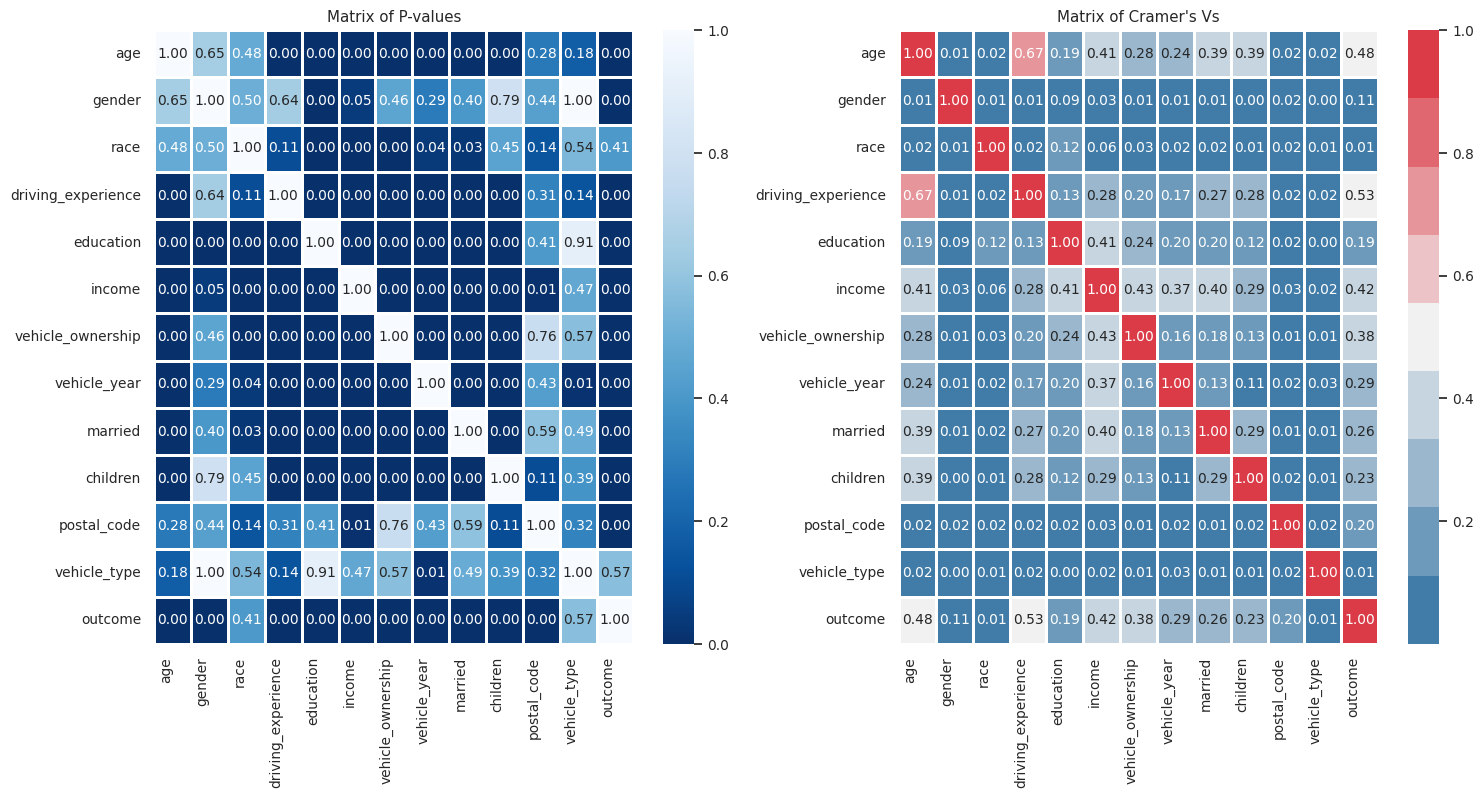

------------------------------------------------------------------------------------------------------------------------
Distributions of the target per columns' categories:
------------------------------------------------------------ END - EXPLORE CATEGORICAL ------------------------------------------------------------


In [ ]:
#@title Explore Correlations of Categorical Features and the Target as a Categorical Column:
df[['outcome']]=df[['outcome']].astype('object')
categorical_correlations(df,plot_contingency=False)

=> -**`outcome` is correlated to `age (0.48)`, `driving exprerience (0.53)` and `income (0.42)` and at a less degree to `vehicle year (0.29)`. *Note: these are Cramer's V values for categorical features with p-value < 5%***

#**POST-EDA OBSERVATIONS AND INSIGHTS:**

##Main Observations and Insights:

- **Outcome is negatively associated** with the number of **past accidents**. **Customers who did not claim for loans have no past accidents**.
- **Outcome is positively associated** with **driving exprerience, age** and **income.**
- **The more speeding violations a customer have, the more `accidents` and `DUIs` he commits.** These are **unattentioned** drivers. In fact, more experienced drivers with **more `annual mileage`**, more stable martial status(married with children) are **more vigilent and commits less `speeding violations`**. Combining this observation with the first one, **the latter group are less in need to apply for a loan from the car insurance company.** In the same context, 9-year driving experienced cutomers and above are also very less probable to claim their loans. These are experienced drivers. **The threshold of 9 years is obvious within the dataset.**
- **More than 95% of drivers do not have DUIS.**
- **Young customers** (less than 26 years old) **apply more often** for loans.
- **Customer owning vehicules are less** probable to **apply for loans**, have already  **higher credit scores** and belong to the **upper class category**.
- **Gender has no effect**.
- **Postal Code and Race despite being very unbalanced do not have a significant direct impact on the outcome, except for a mnim association with class category**.
- Race is not correlated to outcome category and not associated to other features. **Its imbalance is statistically not significant.**

The graphs below shows the variations of the number of 'speeding violations', 'DUIS' and 'vehicle ownership' per 'outcome' and the association of some features with each other (particularly that of speeding violations with the number of DUIS, past accidents and annual mileage), thus illustrating some of the aforementioned insights.

In [78]:
#@title ReLoad Data for Visualization:
df= pd.read_csv(filepath)
df.columns=map(str.lower, df.columns) # same as df.columns = [x.lower() for x in df.columns]

# Filling missing values (this step is only done for visualization purposes)
mean_annual_mileage = df.annual_mileage.mean()
df.annual_mileage = df.annual_mileage.fillna(mean_annual_mileage)
mean_credit_score = df.credit_score.mean()
df.annual_mileage = df.annual_mileage.fillna(mean_credit_score)
# Creating a new feature to regroup the three types of violations
df['incidents']=df.duis+df.past_accidents+df.speeding_violations
# Regrouping credit scores by driving experience and insurance claim(outcome)
credit_score_driving_experience_0=df[df.outcome==0].groupby(by=['driving_experience'])['credit_score'].mean()
credit_score_driving_experience_1=df[df.outcome==1].groupby(by=['driving_experience'])['credit_score'].mean()
# Regrouping credit scores by number of past incidents and insurance claim(outcome)
annual_mileage_incidents_0=df[df.outcome==0].groupby(by=['incidents'])['annual_mileage'].mean()
annual_mileage_incidents_1=df[df.outcome==1].groupby(by=['incidents'])['annual_mileage'].mean()
# Regrouping credit scores income category and insurance claim(outcome)
credit_score_income_own_0=df[df.outcome==0].groupby(by=['income','outcome'])['credit_score'].mean()
credit_score_income_own_1=df[df.outcome==1].groupby(by=['income','outcome'])['credit_score'].mean()

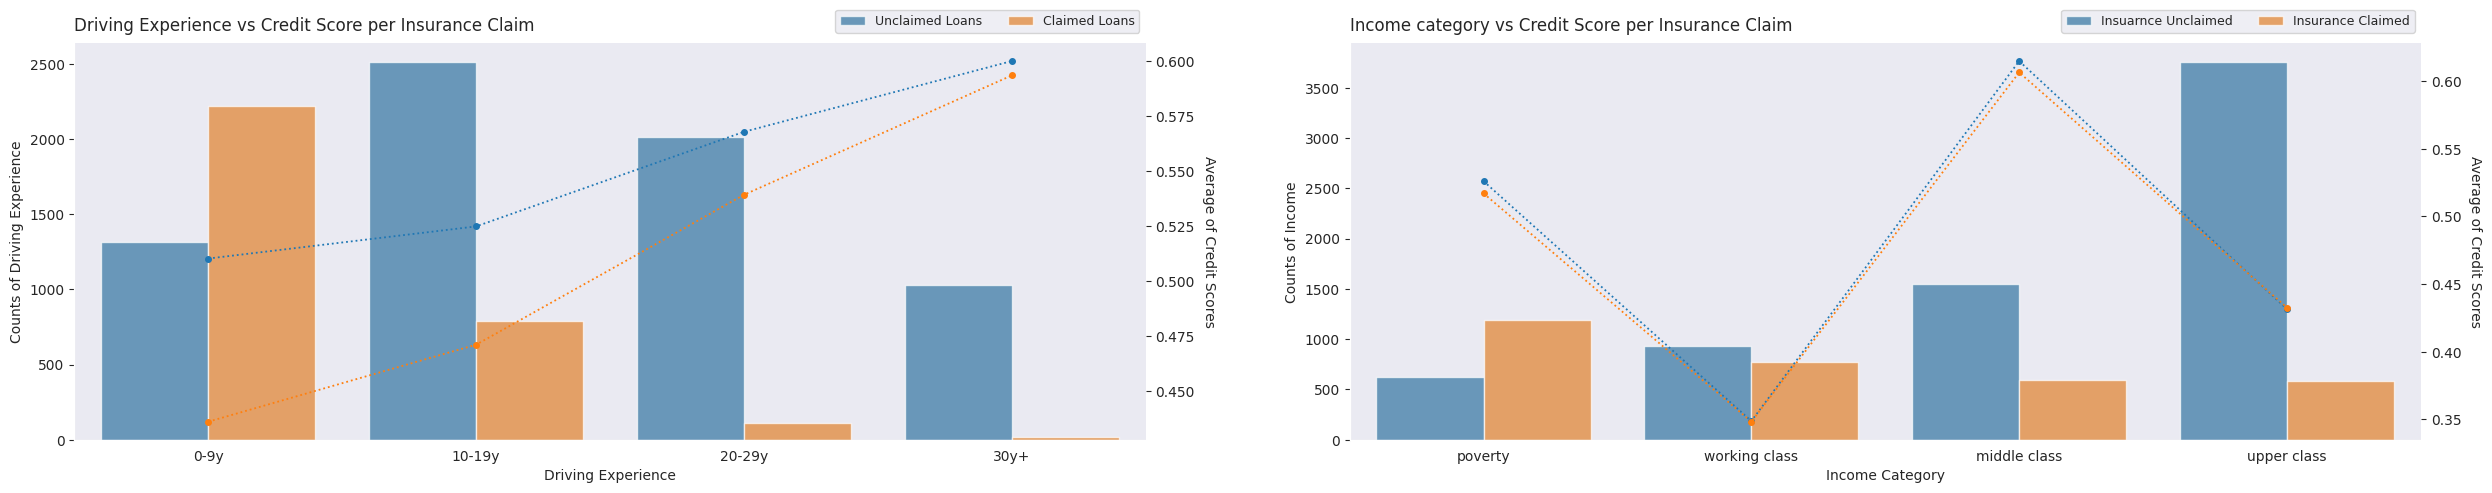

In [92]:
#@title Main Graph 1:
sns.set_style("dark", {'grid.color': 'white'})

fig,axes=plt.subplots(1,2,figsize=(25,5))
axes=axes.flatten()
# Create first graph
axes01=axes[0].twinx()
axes11=axes[1].twinx()
credit_score_driving_experience_0.plot(ax=axes01,markersize=8,marker='.',linewidth=1.3,linestyle='dotted',xticks=[])
credit_score_driving_experience_1.plot(ax=axes01,markersize=8,marker='.',linewidth=1.3,linestyle='dotted',xticks=[])
sns.countplot(df,x='driving_experience',hue='outcome',ax=axes[0],alpha=0.7)
axes[0].set_title('Driving Experience vs Credit Score per Insurance Claim',loc='left',y=1.01)
axes[0].legend(['Unclaimed Loans','Claimed Loans'],bbox_to_anchor=(1,1.1),ncol=2,fontsize=9)
axes[0].set_xlabel('Driving Experience')
axes[0].set_ylabel('Counts of Driving Experience')
axes01.set_ylabel('Average of Credit Scores',rotation=270,labelpad=15)
axes01.grid(False)
# Create second graph
credit_score_income_own_0.plot(ax=axes11,markersize=8,marker='.',linewidth=1.3,linestyle='dotted',xticks=[])
credit_score_income_own_1.plot(ax=axes11,markersize=8,marker='.',linewidth=1.3,linestyle='dotted',xticks=[])
sns.countplot(df,x='income',hue='outcome',ax=axes[1],alpha=0.7,order=['poverty','working class','middle class','upper class'])
axes[1].set_title('Income category vs Credit Score per Insurance Claim',loc='left',y=1.01)
axes[1].legend(['Insuarnce Unclaimed','Insurance Claimed'],bbox_to_anchor=(1,1.1),ncol=2,fontsize=9)
axes[1].set_xlabel('Income Category')
axes[1].set_ylabel('Counts of Income')
axes11.set_ylabel('Average of Credit Scores',rotation=270,labelpad=15)
axes11.grid(False)

# plotting
sns.despine(ax=axes[0],top=True, right=True, bottom=False, left=False)
sns.despine(ax=axes[1],top=True, right=True, bottom=False, left=False)
sns.despine(ax=axes01,top=True, right=True, bottom=False, left=False)
sns.despine(ax=axes11,top=True, right=True, bottom=False, left=False)
plt.tight_layout(pad=1, w_pad=5, h_pad=1)
#saving fig
plt.savefig('graph 1', dpi = 400)

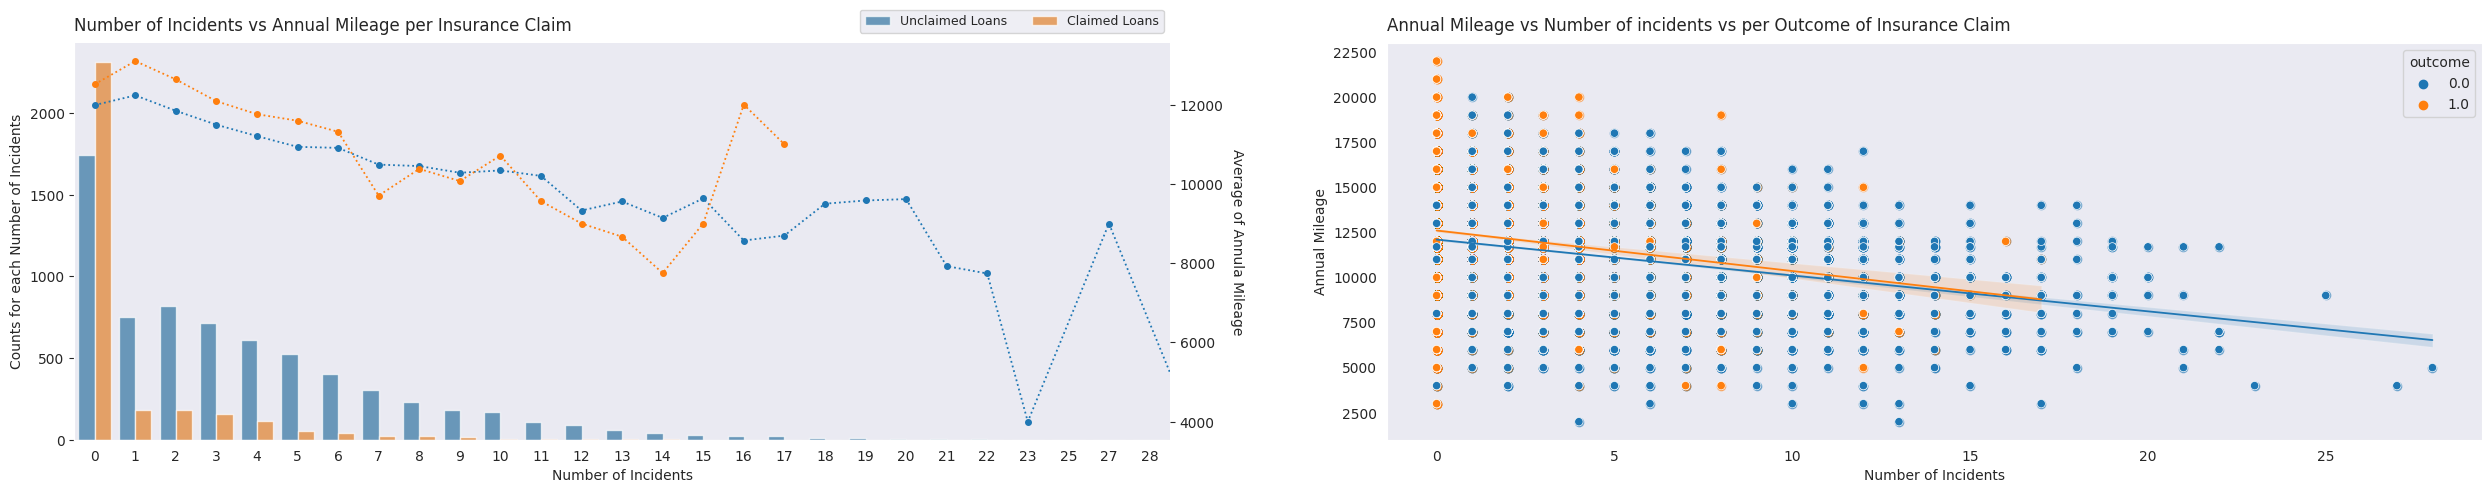

In [93]:
#@title Main Graph 2:
fig,axes=plt.subplots(1,2,figsize=(25,5))
axes=axes.flatten()
# Create first graph
axes01=axes[0].twinx()
annual_mileage_incidents_0.plot(ax=axes01,markersize=8,marker='.',linewidth=1.3,linestyle='dotted',xticks=[])
annual_mileage_incidents_1.plot(ax=axes01,markersize=8,marker='.',linewidth=1.3,linestyle='dotted',xticks=[])
sns.countplot(df,x='incidents',hue='outcome',ax=axes[0],alpha=0.7)
axes[0].set_title('Number of Incidents vs Annual Mileage per Insurance Claim',loc='left',y=1.01)
axes[0].legend(['Unclaimed Loans','Claimed Loans'],bbox_to_anchor=(1,1.1),ncol=2,fontsize=9)
axes[0].set_xlabel('Number of Incidents')
axes[0].set_ylabel('Counts for each Number of Incidents')
axes01.set_ylabel('Average of Annula Mileage',rotation=270,labelpad=15)
axes01.grid(False)
# Create second graph
sns.regplot(x="incidents", y="annual_mileage", data=df[df.outcome==0], scatter_kws={"zorder":-1,"alpha":0.5},ax=axes[1],line_kws={'linewidth':1.3})
sns.regplot(x="incidents", y="annual_mileage", data=df[df.outcome==1], scatter_kws={"zorder":-1,"alpha":0.5},ax=axes[1],line_kws={'linewidth':1.3})
sns.scatterplot(x='incidents', y='annual_mileage', hue='outcome', data=df,ax=axes[1])
axes[1].set_title('Annual Mileage vs Number of incidents vs per Outcome of Insurance Claim',loc='left',y=1.01)
axes[1].set_xlabel('Number of Incidents')
axes[1].set_ylabel('Annual Mileage')
# plotting
sns.despine(ax=axes[0],top=True, right=True, bottom=False, left=False)
sns.despine(ax=axes01,top=True, right=True, bottom=False, left=False)
plt.tight_layout(pad=1, w_pad=5, h_pad=1)
#saving plot
plt.savefig('graph 2', dpi = 400)



#**MAIN DATA PREPROCESSING TO BE CONDUCTED:**

- We will drop `id` column.
- `annual_mileage` and `credit_score` are normally distributed. We will impute them with the mean.
- `duis`, `past_accidents` and `speed_violations` are all positevely correlated betwwen each other and with outcome. Also, the three of them have an exponential distribution with a threshold of 0. We will regroup them in one feature named `incidents`. We will then drop these columns and keep the latter.

 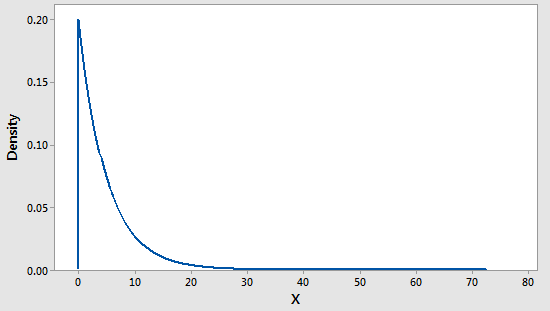
- We will drop `postal_code`, `race` and `gender` since they have no effect on the `outcome`. Note: despite the accentuated imbalances noted in `postal_code` and `race` features, but these **are not statistacally significant**. They will be dropped.
- `annual_mileage` and `driving_experience` are correlated. We will create a new feature named `mileage_experience` that will be equal to `annual_mileage*weight of driving_experience`. The weights will be as follows: `1 for 0-9y`, `2 for 10-19y`, `3 for 20-29y` and `4 for 30y+`. We will then drop these two columns and keep the latter.
- our ***target*** will be `**outcome**`. It is unbalanced so we will apply the **`smote`** technique.
- our ***numerical columns*** will be `**credit_score**`, `**mileage_experience**` and `**incidents**`.
- our ***ordinal columns*** will be `**age**`, `**education**`, `**income**` and `**vehicle_year**`.
- our ***categorical columns*** wille be `**vehicle_ownership**`, `**married**`, `**children**` and `**vehicle_type**`.

#**PREPROCESSING**

In [ ]:
#@title Preprocessing Imports:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sampler_pipeline

In [ ]:
#@title Split Data:
df=pd.read_csv(filepath)
df.columns=map(str.lower, df.columns) # same as df.columns = [x.lower() for x in df.columns]
df[['postal_code','vehicle_ownership','children','married']]=df[['postal_code','vehicle_ownership','children','married']].astype('object')
X = df.drop(columns=['outcome'])
y=df['outcome']
y=y.replace({'0':0,'1':1})

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train.shape, y_train.shape,X_test.shape, y_test.shape

((7500, 18), (7500,), (2500, 18), (2500,))

In [ ]:
#@title Define columns:
num_cols=X_train.select_dtypes('number').columns
ord_cols=X_train[['age','education','income','vehicle_year','driving_experience']].columns
cat_cols=X_train.drop(columns=ord_cols).select_dtypes('object').columns
num_cols,ord_cols,cat_cols,df.shape

(Index(['id', 'credit_score', 'annual_mileage', 'speeding_violations', 'duis',
        'past_accidents'],
       dtype='object'),
 Index(['age', 'education', 'income', 'vehicle_year', 'driving_experience'], dtype='object'),
 Index(['gender', 'race', 'vehicle_ownership', 'married', 'children',
        'postal_code', 'vehicle_type'],
       dtype='object'),
 (10000, 19))

In [ ]:
#@title Imputation:
# instantiate imputer for numerical columns with normal distributions (credit_score and annual_mileage)
imputer_for_ND = SimpleImputer(strategy='mean')
# instantiate imputer for numerical columns with exponential distributions (duis, speeding_violations and past_accidents)
imputer_for_ExD = SimpleImputer(strategy='most_frequent')
# instantiate imputer for categorical and ordinal features
imputer_na = SimpleImputer(strategy='constant',fill_value='NA')

# Apply imputers
X_train[['credit_score','annual_mileage']]=imputer_for_ND.fit_transform(X_train[['credit_score','annual_mileage']])
X_test[['credit_score','annual_mileage']]=imputer_for_ND.transform(X_test[['credit_score','annual_mileage']])

X_train[['duis','speeding_violations','past_accidents']]=imputer_for_ExD.fit_transform(X_train[['duis','speeding_violations','past_accidents']])
X_test[['duis','speeding_violations','past_accidents']]=imputer_for_ExD.transform(X_test[['duis','speeding_violations','past_accidents']])

X_train[ord_cols]=imputer_na.fit_transform(X_train[ord_cols])
X_test[ord_cols]=imputer_na.transform(X_test[ord_cols])

X_train[cat_cols]=imputer_na.fit_transform(X_train[cat_cols])
X_test[cat_cols]=imputer_na.transform(X_test[cat_cols])



In [ ]:
#@title Adding Other Features:
# regroup columns duis, speed_violations and past_accidents in one feature called incidents
X_train['incidents']=X_train['duis']+X_train['past_accidents']+X_train['speeding_violations']
X_test['incidents']=X_test['duis']+X_test['past_accidents']+X_test['speeding_violations']
##add columns weights depending on driving experience
#def weights(x):
#  if x=='0-9y':
#    return 1
#  elif x=='10-19y':
#    return 1.5
#  elif x=='20-29y':
#    return 2
#  elif x=='30y+':
#    return 2.5
#  else:
#    return np.nan
#X_train['weights_experience']=X_train.driving_experience.apply(func=weights)
#X_test['weights_experience']=X_test.driving_experience.apply(func=weights)
##add columns mileage_experience
#X_train['mileage_experience']=X_train['weights_experience']*X_train['annual_mileage']
#X_test['mileage_experience']=X_test['weights_experience']*X_test['annual_mileage']

In [ ]:
#@title Redefine Columns
num_cols = X_train[['credit_score','annual_mileage','incidents']].columns #rest of numerical columns will be dropped in the columns transformer instantiating
ord_cols=ord_cols # same
cat_cols=cat_cols.drop(['race','gender','postal_code'])
num_cols, ord_cols, cat_cols

(Index(['credit_score', 'annual_mileage', 'incidents'], dtype='object'),
 Index(['age', 'education', 'income', 'vehicle_year', 'driving_experience'], dtype='object'),
 Index(['vehicle_ownership', 'married', 'children', 'vehicle_type'], dtype='object'))

In [ ]:
#@title Instantiating Column Transormer:

# Instantiate numeric pipeline
scaler = StandardScaler()
num_pipe=make_pipeline(scaler) # no need for imputer/ imputation was done seperately
num_tuple=('numerical',num_pipe,num_cols)

# Instantiate ordinal pipeline
age_order=['NA','26-39', '40-64', '16-25', '65+']
education_order = ['NA','none','high school', 'university']
income_order = ['NA', 'poverty', 'working class', 'middle class','upper class']
vehicle_year_order= ['NA','before 2015', 'after 2015']
driving_experience_order= ['NA','0-9y','10-19y','20-29y','30y+']

ord_category_orders = [age_order,education_order,income_order,vehicle_year_order,driving_experience_order]
ord_encoder = OrdinalEncoder(categories=ord_category_orders)
scaler_ord = StandardScaler()
ord_pipe = make_pipeline(ord_encoder,scaler_ord) # no need for imputer/ imputation was done seperately
ord_tuple = ('ordinal',ord_pipe,ord_cols)

# Instantiate one hot encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_pipe = make_pipeline(ohe) # no need for imputer/ imputation was done seperately
ohe_tuple = ("categorical",ohe_pipe,cat_cols)

# instantiate ColumnTransformer (# remainder is set to drop so that the column transformer will drop the rest of columns like 'id','past_accidents,etc..)
transformer = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple],
                                verbose_feature_names_out=False, remainder='drop')
transformer


ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['credit_score', 'annual_mileage', 'incidents'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['NA',
                                                                              '26-39',
                                                                              '40-64',
                                                                              '16-25',
                                                                              '65+'],
                                                                             ['NA',
                                                                              'none',
                                                                              'high '
                                                                              'school',
                                                                              'university'],
                                                                             ['NA',
                                                                              'poverty',
                                                                              'working '
                                                                              'class...
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'education', 'income', 'vehicle_year', 'driving_experience'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['vehicle_ownership', 'married', 'children', 'vehicle_type'], dtype='object'))],
                  verbose_feature_names_out=False)

In [ ]:
#@title Transorm Data:
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [ ]:
#@title Handle Unbalanced Target:
smote=SMOTE()
X_train, y_train = smote.fit_resample(X_train,y_train)
X_train.shape,y_train.shape

((10288, 16), (10288,))

#**MODELIZATION:**

In [ ]:
# @title Modeling Imports
# Modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, average_precision_score, PrecisionRecallDisplay, ConfusionMatrixDisplay, RocCurveDisplay
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#@title Create a grid of classifiers with different hyperparameters:

grid_models = [(LogisticRegression(),[{'C':[10**x for x in range(-4,5)],'max_iter':list(range(100,1001,100)),'penalty':['l1','l2'],'solver':['liblinear'],'random_state':[42]}]),
               (GaussianNB(),[{'var_smoothing': [1e-09]}]),
               (DecisionTreeClassifier(),[{'criterion':['gini','entropy'],'max_depth':list(range(1,100,5)),'random_state':[42]}]),
               (RandomForestClassifier(),[{'n_estimators':list(range(1,201,20)),'max_depth':list(range(1,100,5)),'criterion':['gini','entropy'],'random_state':[42]}]),
               (AdaBoostClassifier(),[{'n_estimators':list(range(1,201,20)),'learning_rate':[0.1, 0.3, 0.5, 0.8, 1],'algorithm':['SAMME', 'SAMME.R'], 'random_state':[42]}]),
               (GradientBoostingClassifier(),[{'n_estimators':list(range(1,100,5)),'max_depth':list(range(1,100,5)),'criterion':['friedman_mse','squared_error'],'loss':['deviance','exponential'],'learning_rate':[0.1, 0.3, 0.5, 0.8, 1],'random_state':[42]}]),
               (XGBClassifier(), [{'learning_rate':[0.1, 0.3, 0.5, 0.8, 1], 'eval_metric': ['error']}]),
               (KNeighborsClassifier(),[{'n_neighbors':[5,7, 8, 10], 'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}]),
               (SVC(),[{'C':[0.25,0.5,0.75,1],'kernel':['linear', 'rbf'],'random_state':[42]}])]

In [ ]:
# @title Fit different Classifiers and get best params for each classifier:
# Uncomment code below to fir models. Note: this process might take between 10 to 60 mins
'''
for cls, params in grid_models:
  grid = RandomizedSearchCV(estimator=cls,param_distributions=params,scoring='accuracy',cv=5)
  grid.fit(X_train, y_train)
  best_param=grid.best_params_
  best_accuracy=grid.best_score_
  print('{}:\nBest Accuracy : {:.2f}%'.format(cls,best_accuracy*100))
  print('Best Parameters : ',best_param)
  print('')
  print('----------------')
  print('')

'''

LogisticRegression():
Best Accuracy : 80.87%
Best Parameters :  {'solver': 'liblinear', 'random_state': 42, 'penalty': 'l1', 'max_iter': 700, 'C': 100}

----------------

GaussianNB():
Best Accuracy : 76.35%
Best Parameters :  {'var_smoothing': 1e-09}

----------------

DecisionTreeClassifier():
Best Accuracy : 83.05%
Best Parameters :  {'random_state': 42, 'max_depth': 6, 'criterion': 'entropy'}

----------------

RandomForestClassifier():
Best Accuracy : 85.84%
Best Parameters :  {'random_state': 42, 'n_estimators': 141, 'max_depth': 21, 'criterion': 'gini'}

----------------

AdaBoostClassifier():
Best Accuracy : 82.08%
Best Parameters :  {'random_state': 42, 'n_estimators': 61, 'learning_rate': 1, 'algorithm': 'SAMME.R'}

----------------

GradientBoostingClassifier():
Best Accuracy : 84.79%
Best Parameters :  {'random_state': 42, 'n_estimators': 56, 'max_depth': 11, 'loss': 'exponential', 'learning_rate': 0.1, 'criterion': 'friedman_mse'}

----------------

XGBClassifier(base_scor

##**Evaluating Models**

In [1]:
#@title Logistic Regressor

classifier = LogisticRegression(solver= ['liblinear'], random_state= 42, penalty= ['l1'], max_iter= 700, C= 100)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
ConfusionMatrixDisplay(cm).plot(ax=axes[0])
RocCurveDisplay.from_predictions(y_test, y_pred,ax=axes[1])
PrecisionRecallDisplay.from_predictions(y_test, y_prob,ax=axes[2])
plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
plt.show()

NameError: ignored

In [ ]:
#@title Gaussian Naive Bias

classifier = GaussianNB(var_smoothing= [1e-09])
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
ConfusionMatrixDisplay(cm).plot(ax=axes[0])
RocCurveDisplay.from_predictions(y_test, y_pred,ax=axes[1])
PrecisionRecallDisplay.from_predictions(y_test, y_prob,ax=axes[2])
plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
plt.show()

              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86      1723
         1.0       0.69      0.68      0.69       777

    accuracy                           0.81      2500
   macro avg       0.77      0.77      0.77      2500
weighted avg       0.80      0.81      0.81      2500

ROC AUC score: 0.8578591857756107
Accuracy Score:  0.8056


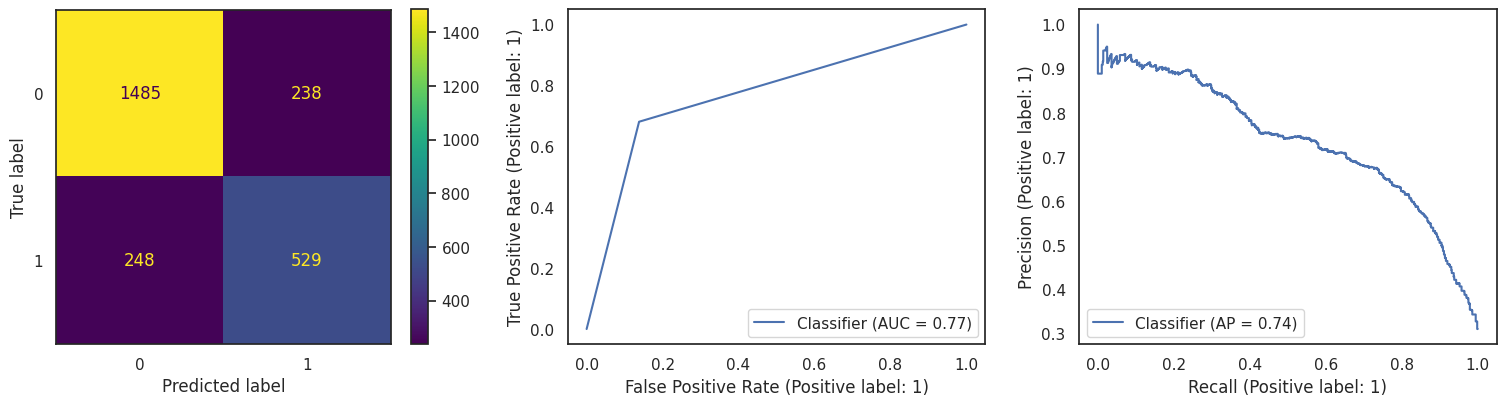

In [ ]:
#@title Evaluate Random Forest Classifier

classifier = RandomForestClassifier(random_state= 42, n_estimators= 141, max_depth= 21, criterion= 'gini')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
ConfusionMatrixDisplay(cm).plot(ax=axes[0])
RocCurveDisplay.from_predictions(y_test, y_pred,ax=axes[1])
PrecisionRecallDisplay.from_predictions(y_test, y_prob,ax=axes[2])
plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
plt.show()

              precision    recall  f1-score   support

         0.0       0.90      0.83      0.86      1723
         1.0       0.67      0.79      0.72       777

    accuracy                           0.81      2500
   macro avg       0.78      0.81      0.79      2500
weighted avg       0.83      0.81      0.82      2500

ROC AUC score: 0.8706343355211608
Accuracy Score:  0.8144


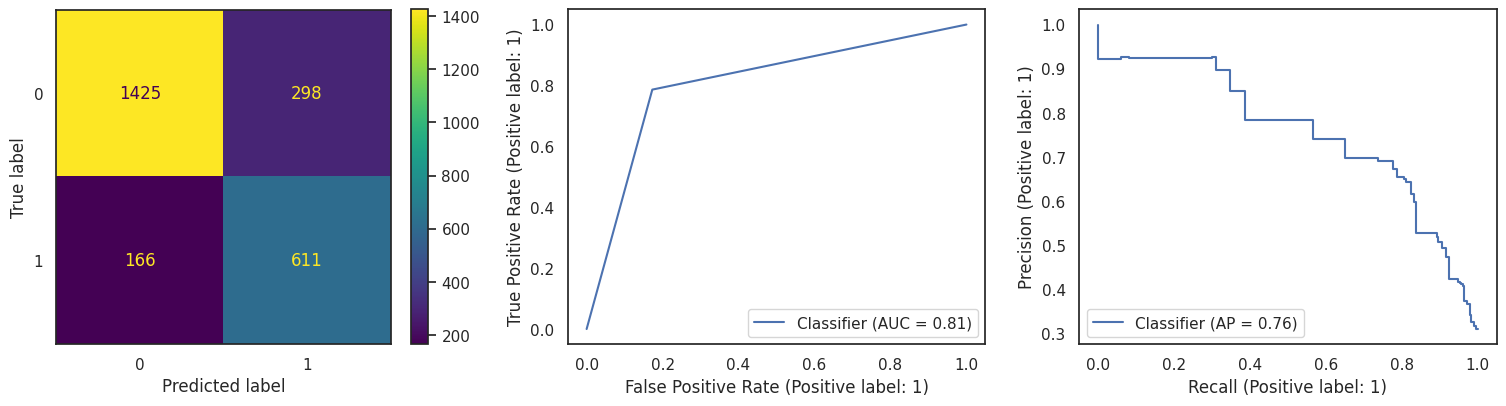

In [ ]:
#@title Evaluate DecisionTreeClassifier

classifier = DecisionTreeClassifier(random_state= 42, max_depth= 6, criterion= 'entropy')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
ConfusionMatrixDisplay(cm).plot(ax=axes[0])
RocCurveDisplay.from_predictions(y_test, y_pred,ax=axes[1])
PrecisionRecallDisplay.from_predictions(y_test, y_prob,ax=axes[2])
plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
plt.show()

In [ ]:
#@title Evaluate AdaBoostClassifier

classifier = AdaBoostClassifier(random_state= 42, n_estimators= 61, learning_rate= 1, algorithm= ['SAMME.R'])
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
ConfusionMatrixDisplay(cm).plot(ax=axes[0])
RocCurveDisplay.from_predictions(y_test, y_pred,ax=axes[1])
PrecisionRecallDisplay.from_predictions(y_test, y_prob,ax=axes[2])
plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
plt.show()

              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86      1723
         1.0       0.68      0.72      0.70       777

    accuracy                           0.81      2500
   macro avg       0.78      0.78      0.78      2500
weighted avg       0.81      0.81      0.81      2500

ROC AUC score: 0.8617183222522746
Accuracy Score:  0.8076


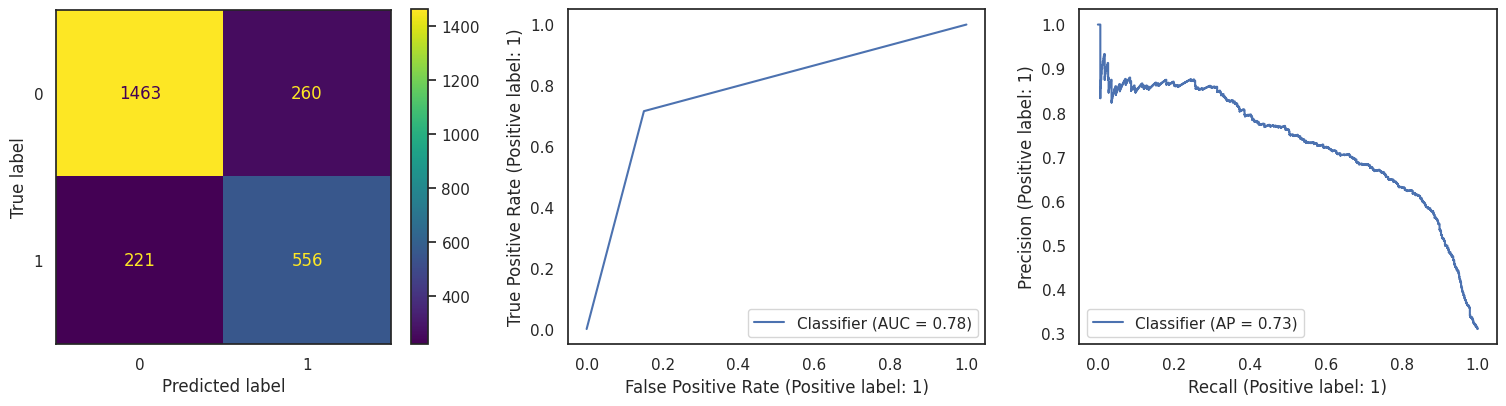

In [ ]:
#@title Evaluate GradientBoostingClassifier

classifier = GradientBoostingClassifier(random_state= 42, n_estimators= 56, max_depth= 11, loss= 'exponential', learning_rate= 0.1, criterion= 'friedman_mse')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
ConfusionMatrixDisplay(cm).plot(ax=axes[0])
RocCurveDisplay.from_predictions(y_test, y_pred,ax=axes[1])
PrecisionRecallDisplay.from_predictions(y_test, y_prob,ax=axes[2])
plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
plt.show()

              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87      1723
         1.0       0.70      0.76      0.73       777

    accuracy                           0.83      2500
   macro avg       0.80      0.81      0.80      2500
weighted avg       0.83      0.83      0.83      2500

ROC AUC score: 0.8788612839686549
Accuracy Score:  0.8264


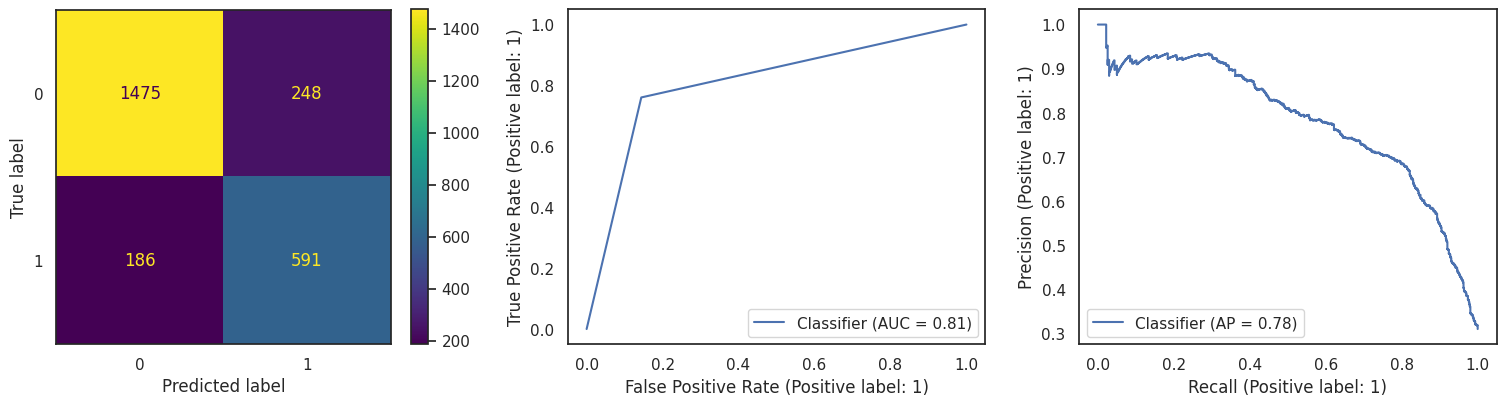

In [ ]:
#@title Evaluate XGBClassifier

classifier = XGBClassifier(learning_rate= 0.1, eval_metric= 'error')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
ConfusionMatrixDisplay(cm).plot(ax=axes[0])
RocCurveDisplay.from_predictions(y_test, y_pred,ax=axes[1])
PrecisionRecallDisplay.from_predictions(y_test, y_prob,ax=axes[2])
plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
plt.show()

In [ ]:
#@title Evaluate KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors= 10, metric= 'manhattan')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
ConfusionMatrixDisplay(cm).plot(ax=axes[0])
RocCurveDisplay.from_predictions(y_test, y_pred,ax=axes[1])
PrecisionRecallDisplay.from_predictions(y_test, y_prob,ax=axes[2])
plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
plt.show()

In [ ]:
#@title Evaluate SVC

classifier = SVC(random_state= 42, kernel= 'rbf', C= 1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
ConfusionMatrixDisplay(cm).plot(ax=axes[0])
RocCurveDisplay.from_predictions(y_test, y_pred,ax=axes[1])
PrecisionRecallDisplay.from_predictions(y_test, y_prob,ax=axes[2])
plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
plt.show()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 15)                240       
                                                                 
 dense_88 (Dense)            (None, 7)                 112       
                                                                 
 dense_89 (Dense)            (None, 3)                 24        
                                                                 
 dense_90 (Dense)            (None, 1)                 4         
                                                                 
Total params: 380 (1.48 KB)
Trainable params: 380 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


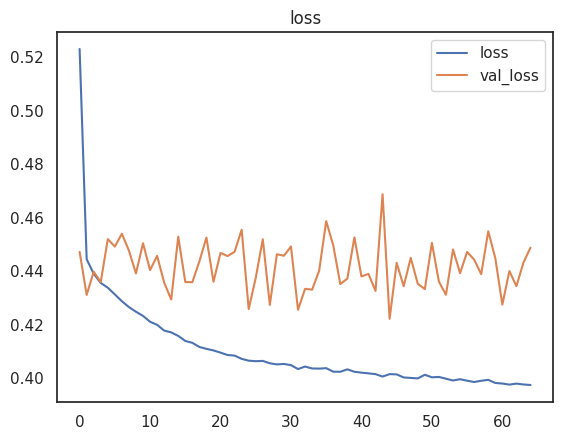

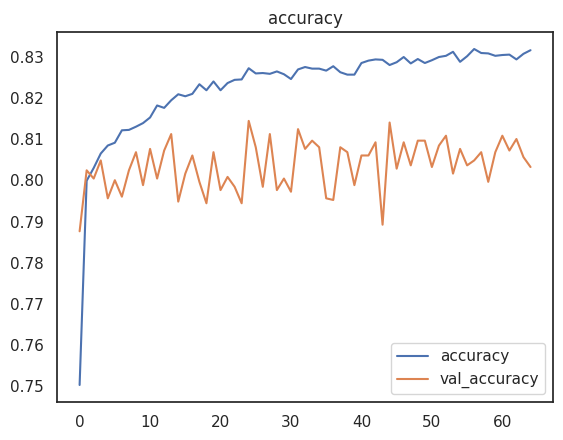

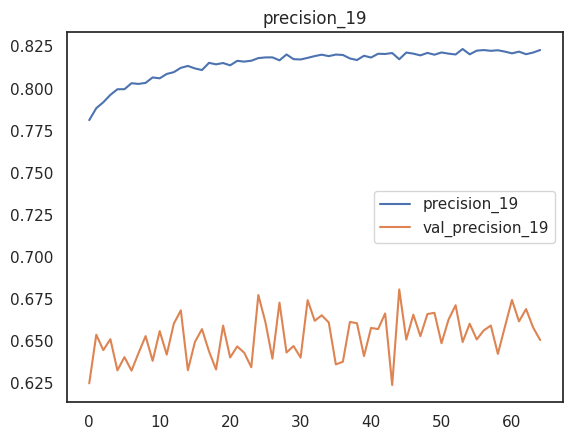

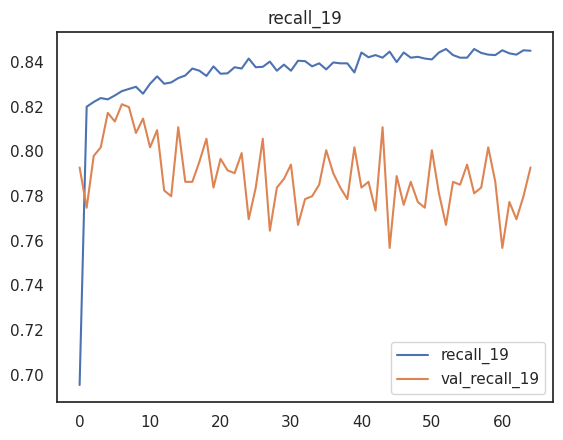

In [ ]:
create_dense_classifier(X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,\
                       model=Sequential(),nbr_layers=1,activ_fun='relu',epochs=150,verbose=False,es=True,patience=20,vis=False,dropout=0,loss='bce')